## Sentiment analysis with LSTM (Deep learning)

* Tokenize the imported data with POS tagging

In [3]:
def read_documents(filename):
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:]
        
    return documents
    
train_docs = read_documents("/Users/shim/dl-python-SentimentAnalysis/data/ratings_train.txt")
test_docs = read_documents("/Users/shim/dl-python-SentimentAnalysis/data/ratings_test.txt")

In [4]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import json
import os
import re
from pprint import pprint


def text_cleaning(doc):
    # A function to remove letters except Korean.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # How to add a boolean 1.
    # SW.add("there is")
    
    # How to add a stopword 2.
    # Add directly to stopwords-en.txt
    with open(path) as f:
        for word in f:
            SW.add(word)
            
    return SW

def text_tokenizing(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
    
    # extract only nouns for a wordcloud.
    #return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

In [5]:
okt = Okt()
mecab = Mecab()

if os.path.exists('train_docs.json'):
    with open("train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(line[1])]
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    
    with open("train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('test_docs.json'):
    with open("test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(line[1])]
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0']


In [6]:
print(train_data[:3])

[[['진짜', '짜증', '네요', '목소리'], '0'], [['포스터', '보고', '초딩', '영화', '오버', '연기', '조차', '가볍', '구나'], '1'], [['너무', '밓었다그래서보는것을추천한다'], '0']]


* Check basic information to analyze the data.

* Use NLTK libraries for preprocessing.

## Classify with a Deep Neural Network

In [7]:
# Import the required libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

## Set Hyperparameter 

In [19]:
max_words = 35000
max_len = 30   #Maximum length of the network
batch_size = 128
EPOCHS = 100

## Define Network Structure 

In [16]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb = Embedding(max_words,100)
        self.lstm = LSTM(128,dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation = "sigmoid")

    def __call__(self, x , training= None , mask = None):
        x = self.emb(x)
        x = self.lstm(x)
        return self.dense(x)

## Data Preprocessing 

In [14]:
#Make it similar to what you did with svm
x_train = [doc for doc, _ in train_data]

#tokenizing to a form for use by keras
tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(x_train)

#Conversion to put as input to an LSTM
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences([doc for doc, _ in test_data])
y_train = np.array([int(label) for _, label in train_data])
y_test = np.array([int(label) for _, label in test_data])
print(x_train[0])

# zero padding for sizing
x_train = pad_sequences(x_train, value=0, padding='pre', maxlen = max_len)
x_test = pad_sequences(x_test, value=0, padding='pre', maxlen = max_len)
print("\n", x_train[0])

# final conversion to learnable form
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[9, 110, 7, 458]

 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   9 110   7 458]


## Set Model 

In [17]:
#Set the model
model = SimpleLSTM()

# Compile the model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

## Early Stopping Callback

In [18]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

## Run Model 

In [20]:
# Run, save results
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[earlystopper])

Epoch 1/100
1145/1145 [==============================] - 65s 55ms/step - loss: 0.4160 - accuracy: 0.8036 - val_loss: 0.3850 - val_accuracy: 0.8227
Epoch 2/100
1145/1145 [==============================] - 70s 61ms/step - loss: 0.3316 - accuracy: 0.8542 - val_loss: 0.4001 - val_accuracy: 0.8236
Epoch 3/100
1145/1145 [==============================] - 73s 63ms/step - loss: 0.2768 - accuracy: 0.8800 - val_loss: 0.4450 - val_accuracy: 0.8184
Epoch 4/100
1145/1145 [==============================] - 73s 63ms/step - loss: 0.2271 - accuracy: 0.9029 - val_loss: 0.5108 - val_accuracy: 0.8137
Epoch 5/100
1145/1145 [==============================] - 77s 67ms/step - loss: 0.1893 - accuracy: 0.9196 - val_loss: 0.5594 - val_accuracy: 0.8069
Epoch 6/100
1145/1145 [==============================] - 74s 65ms/step - loss: 0.1627 - accuracy: 0.9310 - val_loss: 0.6573 - val_accuracy: 0.8066
Epoch 7/100
1145/1145 [==============================] - 76s 66ms/step - loss: 0.1433 - accuracy: 0.9392 - val_loss: 0

In [21]:
# Model Test
score, acc = model.evaluate(x_test,y_test, batch_size=batch_size)

382/382 [==============================] - 5s 14ms/step - loss: 1.0620 - accuracy: 0.7995


In [23]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  1.0619655847549438
Test Accuracy:  0.7995416522026062


## Loss Visualization 

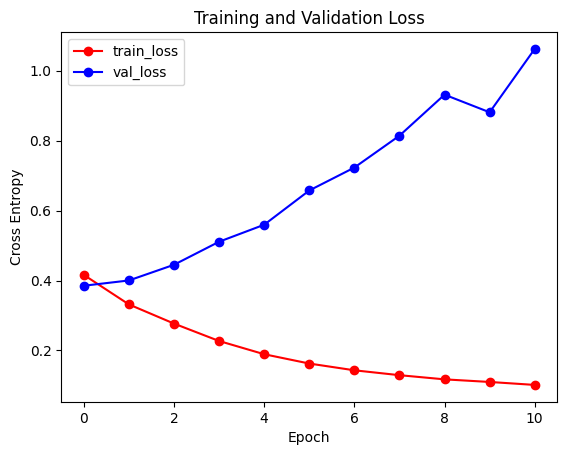

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

## Save Weight 

In [25]:
# Save model weight matrix .
model.save_weights("nsmc_keras_simplelstm")